# DMS Data Processing
### The Data
This notebooks serves as a step-by-step explanation of how the deep mutational scanning (DMS) data sets from Bloom lab at Fred Hutch and Starr lab at University of Utah were processed for our machine learning projects. Here, six data sets are utilized from 3 repos:
- [SARS-CoV-2-RBD_DMS_variants](https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS_variants), paper: [Shifting mutational constraints in the SARS-CoV-2 receptor-binding domain during viral evolution](https://www.science.org/doi/10.1126/science.abo7896)
    - [Binding](https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS_variants/blob/main/results/binding_Kd/bc_binding.csv)
    - [Expression](https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS_variants/blob/main/results/expression_meanF/bc_expression.csv)
    - Variant backgrounds included:
        - Wuhan-Hu-1 background ("wildtype")
        - N501Y (Alpha, found in the B.1.1.7 lineage)
        - K417N+E484K+N501Y (Beta, found in the B.1.351 lineage)
        - E484K (Eta, found in the B.1.525 lineage)
- [SARS-CoV-2-RBD_Delta](https://github.com/jbloomlab/SARS-CoV-2-RBD_Delta/tree/main)
    - [Binding](https://github.com/jbloomlab/SARS-CoV-2-RBD_Delta/blob/main/results/binding_Kd/bc_binding.csv)
    - [Expression](https://github.com/jbloomlab/SARS-CoV-2-RBD_Delta/blob/main/results/expression_meanF/bc_expression.csv)
    - Variant backgrounds included:
        - L452R, T478K (Delta, found in the B.1.617.2 lineage)
- [SARS-CoV-2-RBD_DMS_Omicron](https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS_Omicron), paper: [Deep mutational scans for ACE2 binding, RBD expression, and antibody escape in the SARS-CoV-2 Omicron BA.1 and BA.2 receptor-binding domains](https://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1010951)
    - [Binding](https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS_Omicron/tree/main/results/binding_Kd)
    - [Expression](https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS_Omicron/tree/main/results/expression_meanF)
    - Variant backgrounds included:
        - Wuhan-Hu-1
        - Omicron BA.1
        - Omicron BA.2
- [SARS-CoV-2-RBD_DMS_Omicron-XBB-BQ](https://github.com/tstarrlab/SARS-CoV-2-RBD_DMS_Omicron-XBB-BQ), paper: [Deep mutational scans of XBB.1.5 and BQ.1.1 reveal ongoing epistatic drift during SARS-CoV-2 evolution](https://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1011901)
    - [Binding](https://github.com/tstarrlab/SARS-CoV-2-RBD_DMS_Omicron-XBB-BQ/tree/main/results/binding_Kd)
    - [Expression](https://github.com/tstarrlab/SARS-CoV-2-RBD_DMS_Omicron-XBB-BQ/tree/main/results/expression_meanF)
    - Variant backgrounds included:
        - Omicron XBB.1.5
        - Omicron BQ.1.1
### Processing Steps

In [2]:
import os
import re
import pandas as pd
import numpy as np

Let's load in the data. We'll start with `variants-bc_binding.csv`.

In [3]:
data_dir = './data'

# Load in .csv
variants_binding_csv = os.path.join(data_dir, 'original_dms/variants-bc_binding.csv')
variants_binding_df = pd.read_csv(variants_binding_csv, sep=',', header=0)
variants_binding_df

,library,barcode,target,variant_class,aa_substitutions,n_aa_substitutions,TiteSeq_avgcount,log10Ka
0,pool1A,AAAAAAAAAAAAAGAA,N501Y,1 nonsynonymous,T46Q,1,1.955927,NaN
1,pool1A,AAAAAAAAAAAGGAGA,Wuhan_Hu_1,1 nonsynonymous,G166M,1,0.000000,NaN
2,pool1A,AAAAAAAAAAATTTAA,Wuhan_Hu_1,wildtype,NaN,0,36.004828,8.506648
3,pool1A,AAAAAAAAAACGCGTA,Wuhan_Hu_1,1 nonsynonymous,E154T,1,26.968699,8.586023
4,pool1A,AAAAAAAAAACTCCAA,Wuhan_Hu_1,1 nonsynonymous,F156M,1,40.906723,7.698023
...,...,...,...,...,...,...,...,...
520334,pool2A,TTTTTTTACCGCACTA,B1351,1 nonsynonymous,S19T,1,36.790470,8.275822
520335,pool2A,TTTTTTTAGCATTACC,E484K,wildtype,NaN,0,98.541470,8.312709
520336,pool2A,TTTTTTTGATATTGGA,Wuhan_Hu_1,1 nonsynonymous,C158G,1,38.976891,5.333362
520337,pool2A,TTTTTTTGGGCATGTA,N501Y,>1 nonsynonymous,P54D L183H,2,5.054723,NaN


Let's rename the target column for easier identification.

In [4]:
rename_map = {
    'N501Y': 'Alpha',
    'B1351': 'Beta',
    'Delta': 'Delta',
    'E484K': 'Eta',
    'BA1': 'Omicron_BA1',
    'BA2': 'Omicron_BA2',
    'BQ11': 'Omicron_BQ11',
    'XBB15': 'Omicron_XBB15',
    'Wuhan_Hu_1': 'Wuhan_Hu_1'
}

# Rename target columns for easier variant identification
variants_binding_df['target'] = variants_binding_df['target'].replace(rename_map)

Let's drop any NaN values in the column that contains the `log10Ka` values.

In [5]:
# Remove rows where specified column is NA/N
variants_binding_df = variants_binding_df.dropna(subset=['log10Ka']).reset_index(drop=True)
print(len(variants_binding_df))

431304


Let's take a look at how many of each `variant_class` there are. In the end, we want to filter out any variant classes that are not nonsynonymous mutations.

In [6]:
# Count number of entries per variant class
value_counts = variants_binding_df['variant_class'].value_counts()
print(value_counts)

# Filter out variant classes that are not nonsynonymous
nonsynonymous_df = variants_binding_df[variants_binding_df['variant_class'].str.contains('nonsynonymous', case=False, na=False)]
print(len(nonsynonymous_df))

variant_class
1 nonsynonymous     265843
wildtype            106281
>1 nonsynonymous     57840
synonymous            1340
Name: count, dtype: int64
323683


Now we want to acquire the unique nonsynonymous mutations. We create a column called "label" that consists of the "target" and "aa_substitutions" columns to prevent removal of the same substitutions that occurred for different targets. We'll then group by the "label" column and calculate the mean of the "log10Ka" for each grouping. We'll then merge with the duplicates replaced with the mean "log10Ka", and drop any duplicate label values. This leaves us with our unique nonsynonymous mutation data set.

In [7]:
nonsynonymous_df = nonsynonymous_df.copy()

# Add '_' to aa_substitutions column
nonsynonymous_df.loc[:, 'aa_substitutions'] = nonsynonymous_df['aa_substitutions'].replace(' ', '_', regex=True)

# Create a new column 'label' using 'target' and 'aa_substitutions' columns
nonsynonymous_df['label'] = nonsynonymous_df['target'] + '-' + nonsynonymous_df['aa_substitutions']
print(f"{nonsynonymous_df['label'].value_counts()}\n")

# Group by 'label' and calculate the mean of the specified value column for each group
unique_nonsynonymous_df = nonsynonymous_df.groupby('label', as_index=False)['log10Ka'].mean()
print(len(unique_nonsynonymous_df))

# Merge dfs, replace duplicate with average
merged_df = pd.merge(unique_nonsynonymous_df, nonsynonymous_df.drop(columns='log10Ka'), on='label', how='left')
print(len(merged_df))

# Drop duplicate rows based on 'label'
merged_df = merged_df.drop_duplicates(subset='label').reset_index(drop=True)
print(len(merged_df))

# Count number of unique nonsynonymous mutations
unique_nonsynonymous_mutations_counts = merged_df['label'].nunique()
print(f"Number of unique nonsynonymous mutations: {unique_nonsynonymous_mutations_counts}")

label
Eta-V115L                 153
Eta-N171S                 145
Beta-V32L                 135
Eta-V115S                 128
Eta-V115R                 127
                         ... 
Beta-L131P_D137G            1
Wuhan_Hu_1-L57M_N130K       1
Beta-G117K_Q168D_C195F      1
Eta-Y50R_Y123Q              1
Alpha-S19D_Y159H            1
Name: count, Length: 52763, dtype: int64

52763
323683
52763
Number of unique nonsynonymous mutations: 52763


We need to pull the different variant DNA sequences from the `/data` folders in each of the git repos... for example they look like `PacBio_amplicon_*.gb`, where * is the variant. We want to extract the DNA sequences, convert to RNA, then convert to amino acids. We then use each of these amino acid sequences as the reference sequence to apply the `aa_substitutions` to based on the variant, or `target`.

In [8]:
from Bio import SeqIO
from Bio.Seq import Seq

def extract_refseqs(variants: list) -> dict:
    rename_map = {
    'N501Y': 'Alpha',
    'B1351': 'Beta',
    'Delta': 'Delta',
    'E484K': 'Eta',
    'BA1': 'Omicron_BA1',
    'BA2': 'Omicron_BA2',
    'BQ11': 'Omicron_BQ11',
    'XBB15': 'Omicron_XBB15',
    'Wuhan_Hu_1': 'Wuhan_Hu_1'
    }
    target_dict = {}

    for v in variants:
        amplicon = os.path.join(data_dir, f'amplicons/PacBio_amplicon_{v}.gb')

        # Extract data from genbank file
        data = SeqIO.read(amplicon, 'genbank')

        # Get full sequence, features 
        full_seq = data.seq
        features = data.features

        # Get locations for the "gene", apply to the full sequence
        for feature in features:
            if feature.type == "gene":
                dna_seq = feature.location.extract(full_seq)

        # Convert DNA to RNA
        rna_seq = dna_seq.transcribe()

        # Translate RNA to Amino Acids
        protein_seq= rna_seq.translate()

        # Get the renamed target from the rename_map, default to the original name if not found
        renamed_target = rename_map.get(v, v)

        # Add to target dictionary with the renamed key
        target_dict[renamed_target] = protein_seq
    
    return target_dict

variants = ['Wuhan_Hu_1', 'B1351', 'E484K', 'N501Y']
variants_target_refseqs = extract_refseqs(variants)

for t in variants_target_refseqs: print(f"{t}: {variants_target_refseqs[t]}") 

Wuhan_Hu_1: NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST
Beta: NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST
Eta: NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST
Alpha: NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST


Now that we have the reference sequences for each of the 

In [9]:
def label_to_seq(row, target_refseqs:dict) -> str:
    """ Generate sequence based on reference sequence and aa_substitutions. """
    aa_substitutions, target = row['aa_substitutions'], row['target']
    refseq = list(target_refseqs[target])
    seq = refseq.copy()
    p = '([0-9]+)'
    
    if '_' in aa_substitutions:
        for mutcode in aa_substitutions.split('_'):
            [ori, pos, mut] = re.split(p, mutcode)
            pos = int(pos)-1    # use 0-based counting
            #assert refseq[pos].upper() == ori, f"At {pos}: {refseq[pos]} != {ori}"
            if refseq[pos].upper() != ori: print(f"{target}, At {pos}: {refseq[pos]} != {ori}")
            seq[pos] = mut.upper()
        seq = ''.join(seq)
        return seq

    if aa_substitutions=='': return ''.join(seq)

    [ori, pos, mut] = re.split(p, aa_substitutions)
    pos = int(pos)-1    # use 0-based counting
    #assert refseq[pos].upper() == ori, f"At {pos}: {refseq[pos]} != {ori}"
    if refseq[pos].upper() != ori: print(f"{target}, At {pos}: {refseq[pos]} != {ori}")
    seq[pos] = mut.upper()
    seq = ''.join(seq)    
    return seq

In [10]:
# Filter to only the columns we want and copy the DataFrame to avoid SettingWithCopyWarning
unique_filtered_df = merged_df[['label','target', 'aa_substitutions', 'log10Ka']].copy()

# Utilize 'aa_substitutions' to generate the mutated sequence
unique_filtered_df['sequence'] = unique_filtered_df.apply(label_to_seq, axis=1, target_refseqs=variants_target_refseqs)
unique_filtered_df

,label,target,aa_substitutions,log10Ka,sequence
0,Alpha-A105C,Alpha,A105C,9.086811,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
1,Alpha-A105C_G196Q,Alpha,A105C_G196Q,9.361016,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
2,Alpha-A105C_L162Q,Alpha,A105C_L162Q,6.275086,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3,Alpha-A105D,Alpha,A105D,7.315937,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
4,Alpha-A105D_L111G,Alpha,A105D_L111G,7.150618,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
...,...,...,...,...,...
52758,Wuhan_Hu_1-Y93V_A145V,Wuhan_Hu_1,Y93V_A145V,5.000000,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
52759,Wuhan_Hu_1-Y93V_K128L,Wuhan_Hu_1,Y93V_K128L,5.827319,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
52760,Wuhan_Hu_1-Y93V_N110I,Wuhan_Hu_1,Y93V_N110I,5.263860,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
52761,Wuhan_Hu_1-Y93W,Wuhan_Hu_1,Y93W,5.293445,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...


In [11]:
# Final file pathing
save_as = os.path.join(data_dir, 'processed_dms/mutation_variants-bc_binding.csv')

# Select final columns 
final_df = unique_filtered_df[['label', 'target', 'log10Ka', 'sequence']].copy()

# Save processed data to .csv
final_df.to_csv(save_as, index=False)

Now, let's run this process but on each of the other data sets:

In [12]:
def process_data(target_refseqs, input_csv, output_csv):
    """ 
    Process the DMS binding and expression datasets.
    - Drop NAs
    - Select only nonsynonymous variant classes
    - Select unique nonsynonymous mutations
        - For duplicate aa_substitutions, take the mean value of log10Ka or expression (ML_meanF?)
    - Apply mutations to reference sequence
    """

    if  "binding" in input_csv:
        value_column = "log10Ka"
        print("Looking at DMS binding dataset.")
    elif "expression" in input_csv:
        value_column = "expression"
        print("Looking at DMS expression dataset.")

    full_df = pd.read_csv(input_csv, sep=',', header=0)
    row_count = len(full_df)
    print(f"Number of data points: {row_count}")

    rename_map = {
    'N501Y': 'Alpha',
    'B1351': 'Beta',
    'Delta': 'Delta',
    'E484K': 'Eta',
    'BA1': 'Omicron_BA1',
    'BA2': 'Omicron_BA2',
    'BQ11': 'Omicron_BQ11',
    'XBB15': 'Omicron_XBB15',
    'Wuhan_Hu_1': 'Wuhan_Hu_1'
    }
    # Rename target columns for easier variant identification
    full_df['target'] = full_df['target'].replace(rename_map)

    # Remove rows where specified column is NA
    full_df = full_df.dropna(subset=[value_column]).reset_index(drop=True)
    print(f"Number of data points with na: {row_count-len(full_df)}")
    print(f"Number of data points left {len(full_df)}")
    
    # Count number of entries per variant class
    value_counts = full_df["variant_class"].value_counts()
    print(f"{value_counts}\n")
    # Filter out variant classes that are not nonsynonymous
    nonsynonymous_df = full_df[full_df['variant_class'].str.contains('nonsynonymous', case=False, na=False)]
    # Copy the DataFrame to avoid SettingWithCopyWarning
    nonsynonymous_df = nonsynonymous_df.copy()

    # Add '_' to aa_substitutions column
    nonsynonymous_df.loc[:, 'aa_substitutions'] = nonsynonymous_df['aa_substitutions'].replace(' ', '_', regex=True)
    # Create a new column 'label' using 'target' and 'aa_substitutions' columns
    nonsynonymous_df['label'] = nonsynonymous_df['target'] + '-' + nonsynonymous_df['aa_substitutions']
    print(f"{nonsynonymous_df['label'].value_counts()}\n")
    # Group by 'label' and calculate the mean of the specified value column for each group
    unique_nonsynonymous_df = nonsynonymous_df.groupby('label', as_index=False)[value_column].mean()
    # Merge dfs, replace duplicate with average
    merged_df = pd.merge(unique_nonsynonymous_df, nonsynonymous_df.drop(columns=value_column), on='label', how='left')
    # Drop duplicate rows based on 'label'
    merged_df = merged_df.drop_duplicates(subset='label').reset_index(drop=True)
    # Count number of unique nonsynonymous mutations
    unique_nonsynonymous_mutations_counts = merged_df['label'].nunique()
    print(f"Number of unique nonsynonymous mutations: {unique_nonsynonymous_mutations_counts}")
    
    # Filter to only the columns we want and copy the DataFrame to avoid SettingWithCopyWarning
    unique_filtered_df = merged_df[['label','target', 'aa_substitutions', value_column]].copy()
    # Utilize 'aa_substitutions' to generate the mutated sequence
    unique_filtered_df['sequence'] = unique_filtered_df.apply(label_to_seq, axis=1, target_refseqs=target_refseqs)

    # Select final columns 
    final_df = unique_filtered_df[['label', 'target', value_column, 'sequence']].copy()
    # Save processed data to .csv
    final_df.to_csv(output_csv, index=False)

In [13]:
variants = ['Wuhan_Hu_1', 'B1351', 'E484K', 'N501Y', 'Delta', 'BA1', 'BA2', 'BQ11', 'XBB15']
target_refseqs = extract_refseqs(variants)
for t in target_refseqs: print(f"{t}: {target_refseqs[t]}") 

expression_csv = os.path.join(data_dir, 'original_dms/variants-bc_expression.csv')
save_as = os.path.join(data_dir, 'processed_dms/mutation_variants-bc_expression.csv')
process_data(target_refseqs, expression_csv, save_as)

Wuhan_Hu_1: NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST
Beta: NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST
Eta: NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST
Alpha: NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST
Delta: NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEG

### Delta Dataset

In [14]:
binding_csv = os.path.join(data_dir, 'original_dms/delta-bc_binding.csv')
save_as = os.path.join(data_dir, 'processed_dms/mutation_delta-bc_binding.csv')
process_data(target_refseqs, binding_csv, save_as)

Looking at DMS binding dataset.
Number of data points: 205734
Number of data points with na: 23388
Number of data points left 182346
variant_class
1 nonsynonymous     120999
wildtype             36189
>1 nonsynonymous     24853
synonymous             305
Name: count, dtype: int64

label
Delta-N64W           70
Delta-S45P           66
Delta-K114W          62
Delta-N110S          62
Delta-E154Y          61
                     ..
Delta-T63K_K94M       1
Delta-F126M_S139T     1
Delta-Q79M_Q168H      1
Delta-Y21C_K198C      1
Delta-Y50R_R127P      1
Name: count, Length: 27274, dtype: int64

Number of unique nonsynonymous mutations: 27274


In [15]:
expression_csv = os.path.join(data_dir, 'original_dms/delta-bc_expression.csv')
save_as = os.path.join(data_dir, 'processed_dms/mutation_delta-bc_expression.csv')
process_data(target_refseqs, expression_csv, save_as)

Looking at DMS expression dataset.
Number of data points: 205734
Number of data points with na: 11573
Number of data points left 194161
variant_class
1 nonsynonymous     127540
wildtype             37693
>1 nonsynonymous     26532
stop                  2076
synonymous             320
Name: count, dtype: int64

label
Delta-N64W               71
Delta-S45P               69
Delta-F70R               67
Delta-K114W              64
Delta-R136L              63
                         ..
Delta-A42S_N64W           1
Delta-Y91D_Y165G          1
Delta-K26Q_C49H_C158D     1
Delta-A22K_S108F          1
Delta-G86M_G146Y          1
Name: count, Length: 28729, dtype: int64

Number of unique nonsynonymous mutations: 28729


### 1st Omicron Dataset

In [16]:
binding_csv = os.path.join(data_dir, 'original_dms/omicron_BA-bc_binding.csv')
save_as = os.path.join(data_dir, 'processed_dms/mutation_omicron_BA-bc_binding.csv')
process_data(target_refseqs, binding_csv, save_as)

Looking at DMS binding dataset.
Number of data points: 649481
Number of data points with na: 308459
Number of data points left 341022
variant_class
1 nonsynonymous     320786
>1 nonsynonymous     10613
wildtype              9269
synonymous             354
Name: count, dtype: int64

label
Omicron_XBB15-Y121S          103
Omicron_XBB15-Y121R           87
Omicron_XBB15-V180-           82
Omicron_BQ11-P149S            78
Omicron_XBB15-Y121T           77
                            ... 
Omicron_BA2-R179K_T201Q        1
Omicron_BQ11-A14T_I80M         1
Omicron_XBB15-R73F_A81S        1
Omicron_BA2-K48S_V52F          1
Omicron_XBB15-Y119F_R124T      1
Name: count, Length: 21653, dtype: int64

Number of unique nonsynonymous mutations: 21653


In [17]:
expression_csv = os.path.join(data_dir, 'original_dms/omicron_BA-bc_expression.csv')
save_as = os.path.join(data_dir, 'processed_dms/mutation_omicron_BA-bc_expression.csv')
process_data(target_refseqs, expression_csv, save_as)

Looking at DMS expression dataset.
Number of data points: 598394
Number of data points with na: 97861
Number of data points left 500533
variant_class
1 nonsynonymous     446359
wildtype             25152
>1 nonsynonymous     23048
stop                  5659
synonymous             315
Name: count, dtype: int64

label
Omicron_BA1-S19W           119
Omicron_BA1-Y50G           116
Omicron_BA1-A18W           112
Omicron_BA1-A18Y           112
Omicron_BA1-S19G           111
                          ... 
Omicron_BA1-R27M_D137A       1
Wuhan_Hu_1-S45R_V52P         1
Wuhan_Hu_1-V11Q_S200Q        1
Omicron_BA2-E135N_G172S      1
Omicron_BA2-D68W_C158Y       1
Name: count, Length: 32663, dtype: int64

Number of unique nonsynonymous mutations: 32663


### 2nd Omicron Dataset

In [18]:
binding_csv = os.path.join(data_dir, 'original_dms/omicron_XBB_BQ-bc_binding.csv')
save_as = os.path.join(data_dir, 'processed_dms/mutation_omicron_XBB_BQ-bc_binding.csv')
process_data(target_refseqs, binding_csv, save_as)

Looking at DMS binding dataset.
Number of data points: 598394
Number of data points with na: 163488
Number of data points left 434906
variant_class
1 nonsynonymous     386015
wildtype             27387
>1 nonsynonymous     21159
synonymous             345
Name: count, dtype: int64

label
Omicron_BA1-S19W          99
Omicron_BA1-A18Y          98
Omicron_BA1-A18W          97
Omicron_BA1-A18E          94
Omicron_BA1-Y66W          93
                          ..
Wuhan_Hu_1-F12G_E154H      1
Omicron_BA2-G51A_L111F     1
Omicron_BA1-D59Y_D68K      1
Omicron_BA1-A89S_A154Y     1
Omicron_BA2-D68W_C158Y     1
Name: count, Length: 31244, dtype: int64

Number of unique nonsynonymous mutations: 31244


In [19]:
expression_csv = os.path.join(data_dir, 'original_dms/omicron_XBB_BQ-bc_expression.csv')
save_as = os.path.join(data_dir, 'processed_dms/mutation_omicron_XBB_BQ-bc_expression.csv')
process_data(target_refseqs, expression_csv, save_as)

Looking at DMS expression dataset.
Number of data points: 649481
Number of data points with na: 244004
Number of data points left 405477
variant_class
1 nonsynonymous     375709
>1 nonsynonymous     13002
wildtype             11322
stop                  4990
synonymous             454
Name: count, dtype: int64

label
Omicron_XBB15-V180-          116
Omicron_XBB15-Y121S          112
Omicron_XBB15-Y121R           91
Omicron_BQ11-P149S            84
Omicron_XBB15-Y121T           75
                            ... 
Omicron_XBB15-K132-_E141G      1
Omicron_BQ11-F70L_S139C        1
Omicron_BA2-A22K_W23L          1
Omicron_XBB15-K94E_I138V       1
Omicron_XBB15-Y119F_R124T      1
Name: count, Length: 23680, dtype: int64

Number of unique nonsynonymous mutations: 23680


---

Let's combine all expression and all binding data into 2 big files so we can put them in the ESM-BLSTM model. Get rid of all Wuhan variants. We'll add a column that represents the variant.

### Binding

In [20]:
delta_binding_df = pd.read_csv("./data/processed_dms/mutation_delta-bc_binding.csv", sep=',', header=0)
delta_binding_df = delta_binding_df[delta_binding_df['target'] != 'Wuhan_Hu_1']
delta_binding_df

,label,target,log10Ka,sequence
0,Delta-A105C,Delta,8.599170,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
1,Delta-A105C_L131M,Delta,7.888564,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
2,Delta-A105C_P161S,Delta,6.971465,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3,Delta-A105C_Q176L,Delta,5.000000,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
4,Delta-A105C_T140I,Delta,8.186612,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
...,...,...,...,...
27269,Delta-Y93V_Y121L_A190V,Delta,5.000000,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
27270,Delta-Y93W,Delta,5.307934,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
27271,Delta-Y93W_E135K_F185E,Delta,5.000000,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
27272,Delta-Y93W_G146M,Delta,5.617125,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...


In [21]:
omicron1_binding_df = pd.read_csv("./data/processed_dms/mutation_omicron_BA-bc_binding.csv", sep=',', header=0)
omicron1_binding_df = omicron1_binding_df[omicron1_binding_df['target'] != 'Wuhan_Hu_1']
omicron1_binding_df

,label,target,log10Ka,sequence
0,Omicron_BA2-A105C,Omicron_BA2,8.823195,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
1,Omicron_BA2-A105D,Omicron_BA2,6.241394,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
2,Omicron_BA2-A105D_G196S,Omicron_BA2,6.191784,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
3,Omicron_BA2-A105D_N147M,Omicron_BA2,5.399027,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
4,Omicron_BA2-A105D_S108I,Omicron_BA2,5.174314,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
...,...,...,...,...
21648,Omicron_XBB15-Y93S_S160F,Omicron_XBB15,5.347966,NITNLCPFHEVFNATTFASVYAWNRKRISNCVADYSVIYNFAPFFA...
21649,Omicron_XBB15-Y93T,Omicron_XBB15,6.505274,NITNLCPFHEVFNATTFASVYAWNRKRISNCVADYSVIYNFAPFFA...
21650,Omicron_XBB15-Y93V,Omicron_XBB15,7.076397,NITNLCPFHEVFNATTFASVYAWNRKRISNCVADYSVIYNFAPFFA...
21651,Omicron_XBB15-Y93W,Omicron_XBB15,6.112601,NITNLCPFHEVFNATTFASVYAWNRKRISNCVADYSVIYNFAPFFA...


In [22]:
omicron2_binding_df = pd.read_csv("./data/processed_dms/mutation_omicron_XBB_BQ-bc_binding.csv", sep=',', header=0)
omicron2_binding_df = omicron2_binding_df[omicron2_binding_df['target'] != 'Wuhan_Hu_1']
omicron2_binding_df

,label,target,log10Ka,sequence
0,Omicron_BA1-A105C,Omicron_BA1,8.554372,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFT...
1,Omicron_BA1-A105C_C150Y,Omicron_BA1,5.365723,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFT...
2,Omicron_BA1-A105D,Omicron_BA1,7.165656,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFT...
3,Omicron_BA1-A105E,Omicron_BA1,6.549126,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFT...
4,Omicron_BA1-A105E_D112P,Omicron_BA1,6.795394,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFT...
...,...,...,...,...
17347,Omicron_BA2-Y93V,Omicron_BA2,7.219823,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
17348,Omicron_BA2-Y93V_D97Y,Omicron_BA2,7.320630,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
17349,Omicron_BA2-Y93W,Omicron_BA2,6.970159,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
17350,Omicron_BA2-Y93W_A192T,Omicron_BA2,7.242613,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...


In [23]:
alpha_beta_eta_binding_df = pd.read_csv("./data/processed_dms/mutation_variants-bc_binding.csv", sep=',', header=0)
alpha_beta_eta_binding_df = alpha_beta_eta_binding_df[alpha_beta_eta_binding_df['target'] != 'Wuhan_Hu_1']
alpha_beta_eta_binding_df

,label,target,log10Ka,sequence
0,Alpha-A105C,Alpha,9.086811,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
1,Alpha-A105C_G196Q,Alpha,9.361016,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
2,Alpha-A105C_L162Q,Alpha,6.275086,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3,Alpha-A105D,Alpha,7.315937,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
4,Alpha-A105D_L111G,Alpha,7.150618,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
...,...,...,...,...
39309,Eta-Y93T,Eta,5.892614,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
39310,Eta-Y93V,Eta,5.776665,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
39311,Eta-Y93V_L122Y,Eta,5.000000,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
39312,Eta-Y93W,Eta,5.639833,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...


In [32]:
# Combination
print(27274 + 21653 + 17352 + 39314)
combined_binding_df = pd.concat([delta_binding_df, omicron2_binding_df, omicron1_binding_df, alpha_beta_eta_binding_df], ignore_index=True)
print(sorted(combined_binding_df['target'].unique()))
combined_binding_df = combined_binding_df[['label', 'log10Ka', 'sequence']]
combined_binding_df.to_csv(os.path.join(data_dir, 'processed_dms/mutation_combined_binding.csv'), index=False)
combined_binding_df

105593
['Alpha', 'Beta', 'Delta', 'Eta', 'Omicron_BA1', 'Omicron_BA2', 'Omicron_BQ11', 'Omicron_XBB15']


,label,log10Ka,sequence
0,Delta-A105C,8.599170,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
1,Delta-A105C_L131M,7.888564,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
2,Delta-A105C_P161S,6.971465,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3,Delta-A105C_Q176L,5.000000,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
4,Delta-A105C_T140I,8.186612,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
...,...,...,...
105588,Eta-Y93T,5.892614,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
105589,Eta-Y93V,5.776665,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
105590,Eta-Y93V_L122Y,5.000000,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
105591,Eta-Y93W,5.639833,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...


### Expression

In [25]:
delta_expression_df = pd.read_csv("./data/processed_dms/mutation_delta-bc_expression.csv", sep=',', header=0)
delta_expression_df = delta_expression_df[delta_expression_df['target'] != 'Wuhan_Hu_1']
delta_expression_df

,label,target,expression,sequence
0,Delta-A105C,Delta,8.741343,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
1,Delta-A105C_L131M,Delta,7.336753,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
2,Delta-A105C_P161S,Delta,7.105128,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3,Delta-A105C_Q176L,Delta,6.383087,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
4,Delta-A105C_T140I,Delta,7.823174,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
...,...,...,...,...
28724,Delta-Y93V_Y121L_A190V,Delta,6.209212,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
28725,Delta-Y93W,Delta,6.673510,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
28726,Delta-Y93W_E135K_F185E,Delta,5.795251,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
28727,Delta-Y93W_G146M,Delta,6.329023,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...


In [26]:
omicron1_expression_df = pd.read_csv("./data/processed_dms/mutation_omicron_BA-bc_expression.csv", sep=',', header=0)
omicron1_expression_df = omicron1_expression_df[omicron1_expression_df['target'] != 'Wuhan_Hu_1']
omicron1_expression_df

,label,target,expression,sequence
0,Omicron_BA1-A105C,Omicron_BA1,8.740815,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFT...
1,Omicron_BA1-A105C_C150Y,Omicron_BA1,8.539928,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFT...
2,Omicron_BA1-A105C_S139Y,Omicron_BA1,8.358597,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFT...
3,Omicron_BA1-A105D,Omicron_BA1,8.354743,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFT...
4,Omicron_BA1-A105E,Omicron_BA1,8.458649,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFT...
...,...,...,...,...
19027,Omicron_BA2-Y93V,Omicron_BA2,8.470851,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
19028,Omicron_BA2-Y93V_D97Y,Omicron_BA2,7.699556,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
19029,Omicron_BA2-Y93W,Omicron_BA2,8.376556,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
19030,Omicron_BA2-Y93W_A192T,Omicron_BA2,8.547965,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...


In [27]:
omicron2_expression_df = pd.read_csv("./data/processed_dms/mutation_omicron_XBB_BQ-bc_expression.csv", sep=',', header=0)
omicron2_expression_df = omicron2_expression_df[omicron2_expression_df['target'] != 'Wuhan_Hu_1']
omicron2_expression_df

,label,target,expression,sequence
0,Omicron_BA2-A105C,Omicron_BA2,7.193746,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
1,Omicron_BA2-A105D,Omicron_BA2,6.474038,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
2,Omicron_BA2-A105D_G196S,Omicron_BA2,5.810391,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
3,Omicron_BA2-A105D_K114D,Omicron_BA2,6.537721,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
4,Omicron_BA2-A105D_K114W,Omicron_BA2,6.797881,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...
...,...,...,...,...
23675,Omicron_XBB15-Y93S_S160F,Omicron_XBB15,6.213061,NITNLCPFHEVFNATTFASVYAWNRKRISNCVADYSVIYNFAPFFA...
23676,Omicron_XBB15-Y93T,Omicron_XBB15,6.532637,NITNLCPFHEVFNATTFASVYAWNRKRISNCVADYSVIYNFAPFFA...
23677,Omicron_XBB15-Y93V,Omicron_XBB15,6.547974,NITNLCPFHEVFNATTFASVYAWNRKRISNCVADYSVIYNFAPFFA...
23678,Omicron_XBB15-Y93W,Omicron_XBB15,6.490744,NITNLCPFHEVFNATTFASVYAWNRKRISNCVADYSVIYNFAPFFA...


In [28]:
alpha_beta_eta_expression_df = pd.read_csv("./data/processed_dms/mutation_variants-bc_expression.csv", sep=',', header=0)
alpha_beta_eta_expression_df = alpha_beta_eta_expression_df[alpha_beta_eta_expression_df['target'] != 'Wuhan_Hu_1']
alpha_beta_eta_expression_df

,label,target,expression,sequence
0,Alpha-A105C,Alpha,8.630839,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
1,Alpha-A105C_G196Q,Alpha,8.060150,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
2,Alpha-A105C_L162Q,Alpha,7.083830,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3,Alpha-A105D,Alpha,6.757503,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
4,Alpha-A105D_L111G,Alpha,6.881834,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
...,...,...,...,...
40775,Eta-Y93T,Eta,7.287253,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
40776,Eta-Y93V,Eta,7.620438,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
40777,Eta-Y93V_L122Y,Eta,7.187713,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
40778,Eta-Y93W,Eta,7.246666,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...


In [30]:
# Combination
print(28729 + 19032 + 23680 + 40780)
combined_expression_df = pd.concat([delta_expression_df, omicron2_expression_df, omicron1_expression_df, alpha_beta_eta_expression_df], ignore_index=True)
print(sorted(combined_expression_df['target'].unique()))
combined_expression_df = combined_expression_df[['label', 'expression', 'sequence']]
combined_expression_df.to_csv(os.path.join(data_dir, 'processed_dms/mutation_combined_expression.csv'), index=False)
combined_expression_df

112221
['Alpha', 'Beta', 'Delta', 'Eta', 'Omicron_BA1', 'Omicron_BA2', 'Omicron_BQ11', 'Omicron_XBB15']


,label,expression,sequence
0,Delta-A105C,8.741343,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
1,Delta-A105C_L131M,7.336753,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
2,Delta-A105C_P161S,7.105128,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3,Delta-A105C_Q176L,6.383087,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
4,Delta-A105C_T140I,7.823174,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
...,...,...,...
112216,Eta-Y93T,7.287253,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
112217,Eta-Y93V,7.620438,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
112218,Eta-Y93V_L122Y,7.187713,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
112219,Eta-Y93W,7.246666,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...


### Splitting the data for training/testing

In [30]:
import csv
import random

def split_csv(rnd_seed: int, input_csv: str):
    """
    Split csv file into train, test data.
    """
    train_csv = input_csv.replace('.csv', '_train.csv')
    test_csv  = input_csv.replace('.csv', '_test.csv')

    with open(input_csv, "r") as input_file:
        reader = csv.reader(input_file)
        header = next(reader)
        input_records = list(reader)

    random.seed(rnd_seed)
    random.shuffle(input_records)

    split_idx = int(0.8 * len(input_records))
    train_records = input_records[:split_idx]
    test_records = input_records[split_idx:]

    with open(train_csv, 'w') as ft, open(test_csv, 'w') as fv:
        train_writer = csv.writer(ft)
        test_writer = csv.writer(fv)

        train_writer.writerow(header)
        test_writer.writerow(header)

        for record in train_records:
            train_writer.writerow(record)

        for record in test_records:
            test_writer.writerow(record)

    print(f'Total: {len(input_records)}, Train: {len(train_records)}, Test: {len(test_records)}')

In [33]:
data_dir = './data/processed_dms'
combined_binding_csv = os.path.join(data_dir, 'mutation_combined_binding.csv')
combined_expression_csv = os.path.join(data_dir, 'mutation_combined_expression.csv')

# Split to train, test data (80/20)
rnd_seed = 0
split_csv(rnd_seed, combined_binding_csv)
split_csv(rnd_seed, combined_expression_csv)

Total: 105593, Train: 84474, Test: 21119
Total: 112221, Train: 89776, Test: 22445


### Running through entire dataset using test mode
We'll do this to evaluate the success of the ESM-BLSTM model (that we utilized transfer learning on using original DMS data) on new DMS data.

In [1]:
#!/usr/bin/env python
"""
Model runner for ESM model fed into BLSTM, where ESM embeddings get updated.
"""

import os
import re
import sys
import math
import tqdm
import torch
import time
import datetime
import numpy as np
import pandas as pd
from typing import Union
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel 
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

# BLSTM
class BLSTM(nn.Module):
    """ Bidirectional LSTM with FCN layer. """

    def __init__(self,
                 lstm_input_size,    # The number of expected features.
                 lstm_hidden_size,   # The number of features in hidden state h.
                 lstm_num_layers,    # Number of recurrent layers in LSTM.
                 lstm_bidirectional, # Bidrectional LSTM.
                 fcn_hidden_size):   # The number of features in hidden layer of CN.
        super().__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_size=lstm_input_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=lstm_num_layers,
                            bidirectional=lstm_bidirectional,
                            batch_first=True)           

        # FCN
        if lstm_bidirectional:
            self.fcn = nn.Sequential(nn.Linear(2 * lstm_hidden_size, fcn_hidden_size),
                                     nn.ReLU())
        else:
            self.fcn = nn.Sequential(nn.Linear(lstm_hidden_size, fcn_hidden_size),
                                     nn.ReLU())

        # FCN output layer
        self.out = nn.Linear(fcn_hidden_size, 1)

    def forward(self, x):
        num_directions = 2 if self.lstm.bidirectional else 1
        h_0 = torch.zeros(num_directions * self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device)
        c_0 = torch.zeros(num_directions * self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device)

        lstm_out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        h_n.detach()
        c_n.detach()
        lstm_final_out = lstm_out[:, -1, :]
        fcn_out = self.fcn(lstm_final_out)
        prediction = self.out(fcn_out)

        return prediction

# ESM-BLSTM
class ESM_BLSTM(nn.Module):
    def __init__(self, esm, blstm):
        super().__init__()
        self.esm = esm
        self.blstm = blstm

    def forward(self, tokenized_seqs):
        with torch.set_grad_enabled(self.training):  # Enable gradients, managed by model.eval() or model.train() in epoch_iteration
            esm_output = self.esm(**tokenized_seqs).last_hidden_state
            reshaped_output = esm_output.squeeze(0)  
            output = self.blstm(reshaped_output)
        return output

# DATASET    
class DMSDataset(Dataset):
    """ Binding or Expression DMS Dataset, not from pickle! """
    
    def __init__(self, csv_file:str):
        """
        Load from csv file into pandas:
        - sequence label ('labels'), 
        - binding or expression numerical target ('log10Ka' or 'ML_meanF'), and 
        - 'sequence'
        """
        try:
            self.full_df = pd.read_csv(csv_file, sep=',', header=0)
            self.target = 'log10Ka' if 'binding' in csv_file else 'expression'
        except (FileNotFoundError, pd.errors.ParserError, Exception) as e:
            print(f"Error reading in .csv file: {csv_file}\n{e}", file=sys.stderr)
            sys.exit(1)

    def __len__(self) -> int:
        return len(self.full_df)

    def __getitem__(self, idx):
        # label, seq, target
        return self.full_df['label'][idx], self.full_df['sequence'][idx], self.full_df[self.target][idx]

# HELPER FUNCTIONS
def count_parameters(model):
    """
    Count model parameters and print a summary

    A nice hack from:
    https://stackoverflow.com/a/62508086/1992369
    """
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}\n")
    return total_params

def save_model(model, optimizer, path_to_pth, epoch, loss):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }, path_to_pth
    )
    print(f"Model and optimizer state saved to {path_to_pth}")

def load_model(model, optimizer, saved_model_pth, device):
    saved_state = torch.load(saved_model_pth, map_location=device)
    model.load_state_dict(saved_state['model_state_dict'])
    optimizer.load_state_dict(saved_state['optimizer_state_dict'])
    epoch = saved_state['epoch']
    loss = saved_state['loss']
    print(f"Loaded model from {saved_model_pth} at epoch {epoch}, loss {loss}")
    return model.to(device), optimizer, epoch, loss

def load_model_checkpoint(path_to_pth, metrics_csv, starting_epoch):
    """ Load model data csv, and model pth. """
    folder_path = os.path.dirname(path_to_pth)
    files_in_folder = os.listdir(folder_path)
    metrics_file_name = [file for file in files_in_folder if file.endswith("_metrics.csv")][0]
    saved_metrics_file = os.path.join(folder_path, metrics_file_name)

    with open(saved_metrics_file, "r") as fa, open(metrics_csv, "w") as fb:
        header = fa.readline()
        fb.write(header)

        for line in fa:
            epoch = int(line.split(',')[0])
            if epoch == starting_epoch:
                break
            fb.write(line)

def load_model_from_trained(model, trained_model_pth, device):
    """ 
    Function to load saved weights from the old DMS-trained 
    ESM-BLSTM transfer learning model. 
    """
    saved_state = torch.load(trained_model_pth, map_location=device)
    state_dict = {key.replace('_model', ''): value for key, value in saved_state['model_state_dict'].items()}
    model.load_state_dict(state_dict)
    print(f"Loaded trained model from {trained_model_pth}")
    return model.to(device)

def plot_log_file(metrics_csv, metrics_img):
    df = pd.read_csv(metrics_csv)

    sns.set_theme(style="darkgrid")

    fontsize = 24
    plt.subplots(figsize=(16, 9))
    plt.plot(df['Epoch'], df['Train RMSE'], label='Train RMSE', color='tab:blue', linewidth=3)
    plt.plot(df['Epoch'], df['Test RMSE'], label='Test RMSE', color='tab:orange', linewidth=3)
    plt.xlabel('Epochs', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel('Loss', fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(loc='upper right', fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(metrics_img, format='pdf')

# NOT USED ANYMORE, calculation done in epoch_iteration
def calc_rmse_loss(metrics_csv: str, metrics_img:str):
    """ Calculate the mse and rmse per item (batch independent)"""

    n_train = int(re.search(r'train_(\d+)', metrics_csv).group(1))
    n_test = int(re.search(r'test_(\d+)', metrics_csv).group(1))
    metrics_df = pd.read_csv(metrics_csv, sep=',', header=0)

    # MSE
    # Our train loss saved to csv was the accumulated total squared error, just need to divide to take the mean
    metrics_df['Train Loss MSE'] = metrics_df['Train Loss']/n_train
    metrics_df['Test Loss MSE'] = metrics_df['Test Loss']/n_test

    # RMSE
    metrics_df['Train Loss RMSE'] = np.sqrt(metrics_df['Train Loss MSE'].values)
    metrics_df['Test Loss RMSE'] = np.sqrt(metrics_df['Test Loss MSE'].values)

    metrics_df.to_csv(metrics_csv, index=False)
    plot_log_file(metrics_csv, metrics_img)

# MODEL RUNNING
def run_model(model, tokenizer, train_data_loader, test_data_loader, n_epochs: int, lr:float, max_batch: Union[int, None], device: str, run_dir: str, save_as: str, saved_model_pth:str=None, from_checkpoint:bool=False):
    """ Run a model through train and test epochs. """

    model = model.to(device)
    loss_fn = nn.MSELoss(reduction='sum').to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr)

    starting_epoch = 1
    best_loss = float('inf')

    # Load saved model if provided
    if saved_model_pth is not None:
        model, optimizer, starting_epoch, best_loss = load_model(model, optimizer, saved_model_pth, device)
        starting_epoch += 1

    start_time = time.time()
    
    metrics_csv = os.path.join(run_dir, f"{save_as}_metrics.csv")
    metrics_img = os.path.join(run_dir, f"{save_as}_metrics.pdf")
    
    # If saved model, skip to predictions 
    # Except when from checkpoint (still need saved model)
    if saved_model_pth is None or (from_checkpoint and saved_model_pth is not None):

        if starting_epoch > n_epochs:
            raise ValueError(f"Starting epoch ({starting_epoch}) is greater than the total number of epochs to run ({n_epochs}). Adjust the number of epochs, 'n_epochs'.")
        
        with open(metrics_csv, "a") as fa:
            if from_checkpoint: load_model_checkpoint(saved_model_pth, metrics_csv, starting_epoch)
            else: fa.write(f"Epoch,Train MSE,Train RMSE,Test MSE,Test RMSE\n")

            for epoch in range(starting_epoch, n_epochs + 1):
                if not max_batch:
                    max_batch = len(train_data_loader)

                train_mse, train_rmse = epoch_iteration(model, tokenizer, loss_fn, optimizer, train_data_loader, epoch, max_batch, device, mode='train')
                test_mse, test_rmse = epoch_iteration(model, tokenizer, loss_fn, optimizer, test_data_loader, epoch, max_batch, device, mode='test')

                print(f'Epoch {epoch} | Train MSE Loss: {train_mse:.4f}, Train RMSE Loss: {train_rmse:.4f}')
                print(f'{" "*(7+len(str(epoch)))}| Test MSE Loss: {test_mse:.4f}, Test RMSE Loss: {test_rmse:.4f}\n')          
                fa.write(f"{epoch},{train_mse},{train_rmse},{test_mse},{test_rmse}\n")
                fa.flush()

                if test_rmse < best_loss:
                    best_loss = test_rmse
                    model_path = os.path.join(run_dir, f'best_saved_model.pth')
                    print(f"NEW BEST model: loss {best_loss:.4f}")
                    save_model(model, optimizer, model_path, epoch, best_loss)
                
                model_path = os.path.join(run_dir, f'checkpoint_saved_model.pth')
                save_model(model, optimizer, model_path, epoch, test_rmse)
                print("")
        
        plot_log_file(metrics_csv, metrics_img)

    # End timer and print duration
    end_time = time.time()
    duration = end_time - start_time
    print(f'Training and testing complete in {duration:.2f} seconds.')

def epoch_iteration(model, tokenizer, loss_fn, optimizer, data_loader, epoch, max_batch, device, mode):
    """ Used in run_model. """
    
    model.train() if mode=='train' else model.eval()

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Epoch_{mode}: {epoch}',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_loss = 0
    total_items = 0

    for batch, batch_data in data_iter:
        if max_batch > 0 and batch >= max_batch:
            break

        _, seqs, targets = batch_data
        targets = targets.to(device).float()
        tokenized_seqs = tokenizer(seqs,return_tensors="pt").to(device)
   
        if mode == 'train':
            optimizer.zero_grad()
            pred = model(tokenized_seqs).flatten()
            batch_loss = loss_fn(pred, targets)
            batch_loss.backward()
            optimizer.step()

        else:
            with torch.no_grad():
                pred = model(tokenized_seqs).flatten()
                batch_loss = loss_fn(pred, targets)

        total_loss += batch_loss.item()
        total_items += targets.size(0)
    
    # total loss is the sum of squared errors over items encountered
    # so divide by the number of items encountered
    # we get mse and rmse per item
    mse = total_loss/total_items
    rmse = np.sqrt(mse)

    return mse, rmse    
 
def run_test_only(model, tokenizer, data_loader, device: str):
    """ Run a model through 1 test epoch. """

    model = model.to(device)
    loss_fn = nn.MSELoss(reduction='sum').to(device)

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Evaluation',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_loss = 0    
    total_items = 0

    for _, batch_data in data_iter:

        _, seqs, targets = batch_data
        targets = targets.to(device).float()
        tokenized_seqs = tokenizer(seqs,return_tensors="pt").to(device)
   
   
        model.eval()
        with torch.no_grad():
            pred = model(tokenized_seqs).flatten()
            batch_loss = loss_fn(pred, targets)

        total_loss += batch_loss.item()
        total_items += targets.size(0)

    # total loss is the sum of squared errors over items encountered
    # so divide by the number of items encountered
    # we get mse and rmse per item
    mse = total_loss/total_items
    rmse = np.sqrt(mse)

    return mse, rmse        

/data/miniconda3/envs/spike_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's take a look at the new DMS binding dataset. We'll run it twice: first with the non-pretrained ESM-BLSTM (starting from pretrained ESM), and second using the pretrained ESM-BLSTM (starting from pretrained ESM). We'll do this comparison to see how well the finetuning performs.

After, we'll do the same for the new DMS expression dataset. There will be a table at the end to compare.

In [9]:
evaluation_results = {}

# Data directories
data_dir = './data/processed_dms'

# Run setup
batch_size = 32
num_workers = 64
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Create Dataset and DataLoader
torch.manual_seed(0)

dms_binding_csv = os.path.join(data_dir, 'mutation_combined_binding.csv') # binding
trained_binding_model_pth = "../results/run_results/esm-blstm/esm-blstm-esm_dms_binding-2023-12-12_17-02/esm-blstm-esm_dms_binding-2023-12-12_17-02_train_84420_test_21105.model_save"

binding_dataset = DMSDataset(dms_binding_csv)
binding_data_loader = DataLoader(binding_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

# ESM input
esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

b_model = ESM_BLSTM(esm, blstm)

# Run prior to loading
mse, rmse = run_test_only(b_model, tokenizer, binding_data_loader, device)
print(f'Binding Evaluation | MSE Loss: {mse:.4f} | RMSE Loss: {rmse:.4f}')
entry = {
    'Model': 'Non-Pretrained Binding',
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['Non-Pretrained Binding'] = entry

# Run after loading
load_model_from_trained(b_model, trained_binding_model_pth, device)
mse, rmse = run_test_only(b_model, tokenizer, binding_data_loader, device)
print(f'Binding Evaluation | MSE Loss: {mse:.4f} | RMSE Loss: {rmse:.4f}')

entry = {
    'Model': 'Pretrained Binding',
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['Pretrained Binding'] = entry

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluation: 100%|| 3300/3300 [01:31<00:00, 36.07it/s]

Binding Evaluation | MSE Loss: 63.1229 | RMSE Loss: 7.9450
Loaded trained model from ../results/run_results/esm-blstm/esm-blstm-esm_dms_binding-2023-12-12_17-02/esm-blstm-esm_dms_binding-2023-12-12_17-02_train_84420_test_21105.model_save



Evaluation: 100%|| 3300/3300 [01:31<00:00, 36.26it/s]

Binding Evaluation | MSE Loss: 4.3591 | RMSE Loss: 2.0879


In [11]:
# Data directories
data_dir = './data/processed_dms'

# Run setup
batch_size = 32
num_workers = 64
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Create Dataset and DataLoader
torch.manual_seed(0)

dms_expression_csv = os.path.join(data_dir, 'mutation_combined_expression.csv') # expression
trained_expression_model_pth = "../results/run_results/esm-blstm/esm-blstm-esm_dms_expression-2023-12-12_16-58/esm-blstm-esm_dms_expression-2023-12-12_16-58_train_93005_test_23252.model_save"

expression_dataset = DMSDataset(dms_expression_csv)
expression_data_loader = DataLoader(expression_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

# ESM input
esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

e_model = ESM_BLSTM(esm, blstm)

# Run prior to loading
mse, rmse = run_test_only(e_model, tokenizer, expression_data_loader, device)
print(f'Expression Evaluation | MSE: {mse:.4f} | RMSE: {rmse:.4f}')
entry = {
    'Model': 'Non-Pretrained Expression',
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['Non-Pretrained Expression'] = entry

# Run after loading
load_model_from_trained(e_model, trained_expression_model_pth, device)
mse, rmse = run_test_only(e_model, tokenizer, expression_data_loader, device)
print(f'Expression Evaluation | MSE: {mse:.4f} | RMSE: {rmse:.4f}')

entry = {
    'Model': 'Pretrained Expression',
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['Pretrained Expression'] = entry

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluation: 100%|| 3507/3507 [01:36<00:00, 36.43it/s]


Expression Evaluation | MSE: 69.8221 | RMSE: 8.3560
Loaded trained model from ../results/run_results/esm-blstm/esm-blstm-esm_dms_expression-2023-12-12_16-58/esm-blstm-esm_dms_expression-2023-12-12_16-58_train_93005_test_23252.model_save


Evaluation: 100%|| 3507/3507 [01:37<00:00, 35.86it/s]

Expression Evaluation | MSE: 0.9754 | RMSE: 0.9876


In [12]:
# Convert the dictionary values to a pandas DataFrame
evaluation_results_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
evaluation_results_df.reset_index(drop=True, inplace=True)
evaluation_results_df

,Model,MSE,RMSE
0,Non-Pretrained Binding,63.122945,7.944995
1,Pretrained Binding,4.359140,2.087855
2,Non-Pretrained Expression,69.822063,8.355960
3,Pretrained Expression,0.975368,0.987607


### Running the model on both training/testing modes using the split data
We'll do this as an example to continue training the model on the DMS data to see if performance improves, but this will actually be fully ran in `Spike_NLP_kaetlyn/new_dms/esm_blstm_model_runner.py`

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded trained model from ../results/run_results/esm-blstm/esm-blstm-esm_dms_binding-2023-12-12_17-02/esm-blstm-esm_dms_binding-2023-12-12_17-02_train_84420_test_21105.model_save
+---------------------------------------------------+------------+
|                      Modules                      | Parameters |
+---------------------------------------------------+------------+
|       esm.embeddings.word_embeddings.weight       |   10560    |
|     esm.embeddings.position_embeddings.weight     |   328320   |
|  esm.encoder.layer.0.attention.self.query.weight  |   102400   |
|   esm.encoder.layer.0.attention.self.query.bias   |    320     |
|   esm.encoder.layer.0.attention.self.key.weight   |   102400   |
|    esm.encoder.layer.0.attention.self.key.bias    |    320     |
|  esm.encoder.layer.0.attention.self.value.weight  |   102400   |
|   esm.encoder.layer.0.attention.self.value.bias   |    320     |
| esm.encoder.layer.0.attention.output.dense.weight |   102400   |
|  esm.encoder.la

Epoch_test: 1: 100%|| 660/660 [00:18<00:00, 36.55it/s]


Epoch 1 | Train MSE Loss: 0.5387, Train RMSE Loss: 0.7339
        | Test MSE Loss: 0.4492, Test RMSE Loss: 0.6702

NEW BEST model: loss 0.6702
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 2: 100%|| 660/660 [00:17<00:00, 36.73it/s]


Epoch 2 | Train MSE Loss: 0.4240, Train RMSE Loss: 0.6512
        | Test MSE Loss: 0.4170, Test RMSE Loss: 0.6457

NEW BEST model: loss 0.6457
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 3: 100%|| 660/660 [00:18<00:00, 36.65it/s]

Epoch 3 | Train MSE Loss: 0.3881, Train RMSE Loss: 0.6230
        | Test MSE Loss: 0.4223, Test RMSE Loss: 0.6498

Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth




Epoch_test: 4: 100%|| 660/660 [00:24<00:00, 26.88it/s]


Epoch 4 | Train MSE Loss: 0.3653, Train RMSE Loss: 0.6044
        | Test MSE Loss: 0.3956, Test RMSE Loss: 0.6290

NEW BEST model: loss 0.6290
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 5: 100%|| 660/660 [00:18<00:00, 35.94it/s]


Epoch 5 | Train MSE Loss: 0.3488, Train RMSE Loss: 0.5906
        | Test MSE Loss: 0.3950, Test RMSE Loss: 0.6285

NEW BEST model: loss 0.6285
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 6: 100%|| 660/660 [00:27<00:00, 23.67it/s]


Epoch 6 | Train MSE Loss: 0.3348, Train RMSE Loss: 0.5786
        | Test MSE Loss: 0.3866, Test RMSE Loss: 0.6217

NEW BEST model: loss 0.6217
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 7: 100%|| 660/660 [00:26<00:00, 24.79it/s]


Epoch 7 | Train MSE Loss: 0.3231, Train RMSE Loss: 0.5685
        | Test MSE Loss: 0.4158, Test RMSE Loss: 0.6448

Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 8: 100%|| 660/660 [00:17<00:00, 36.70it/s]


Epoch 8 | Train MSE Loss: 0.3119, Train RMSE Loss: 0.5584
        | Test MSE Loss: 0.3889, Test RMSE Loss: 0.6236

Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 9: 100%|| 660/660 [00:18<00:00, 36.39it/s]


Epoch 9 | Train MSE Loss: 0.3027, Train RMSE Loss: 0.5502
        | Test MSE Loss: 0.3846, Test RMSE Loss: 0.6201

NEW BEST model: loss 0.6201
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 10: 100%|| 660/660 [00:18<00:00, 36.28it/s]


Epoch 10 | Train MSE Loss: 0.2928, Train RMSE Loss: 0.5411
         | Test MSE Loss: 0.3835, Test RMSE Loss: 0.6193

NEW BEST model: loss 0.6193
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 11: 100%|| 660/660 [00:18<00:00, 36.63it/s]


Epoch 11 | Train MSE Loss: 0.2848, Train RMSE Loss: 0.5336
         | Test MSE Loss: 0.3894, Test RMSE Loss: 0.6240

Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 12: 100%|| 660/660 [00:18<00:00, 36.56it/s]


Epoch 12 | Train MSE Loss: 0.2761, Train RMSE Loss: 0.5255
         | Test MSE Loss: 0.3799, Test RMSE Loss: 0.6164

NEW BEST model: loss 0.6164
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 13: 100%|| 660/660 [00:18<00:00, 36.59it/s]


Epoch 13 | Train MSE Loss: 0.2688, Train RMSE Loss: 0.5184
         | Test MSE Loss: 0.3919, Test RMSE Loss: 0.6260

Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 14: 100%|| 660/660 [00:18<00:00, 36.23it/s]


Epoch 14 | Train MSE Loss: 0.2616, Train RMSE Loss: 0.5115
         | Test MSE Loss: 0.3868, Test RMSE Loss: 0.6219

Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 15: 100%|| 660/660 [00:25<00:00, 25.84it/s]


Epoch 15 | Train MSE Loss: 0.2536, Train RMSE Loss: 0.5036
         | Test MSE Loss: 0.3769, Test RMSE Loss: 0.6140

NEW BEST model: loss 0.6140
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 16: 100%|| 660/660 [00:24<00:00, 27.33it/s]


Epoch 16 | Train MSE Loss: 0.2456, Train RMSE Loss: 0.4956
         | Test MSE Loss: 0.3832, Test RMSE Loss: 0.6190

Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 17: 100%|| 660/660 [00:18<00:00, 36.23it/s]


Epoch 17 | Train MSE Loss: 0.2388, Train RMSE Loss: 0.4887
         | Test MSE Loss: 0.3873, Test RMSE Loss: 0.6223

Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 18: 100%|| 660/660 [00:18<00:00, 36.63it/s]

Epoch 18 | Train MSE Loss: 0.2315, Train RMSE Loss: 0.4812
         | Test MSE Loss: 0.3876, Test RMSE Loss: 0.6226

Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth




Epoch_test: 19: 100%|| 660/660 [00:18<00:00, 36.58it/s]


Epoch 19 | Train MSE Loss: 0.2239, Train RMSE Loss: 0.4732
         | Test MSE Loss: 0.3872, Test RMSE Loss: 0.6222

Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth



Epoch_test: 20: 100%|| 660/660 [00:17<00:00, 36.68it/s]


Epoch 20 | Train MSE Loss: 0.2177, Train RMSE Loss: 0.4666
         | Test MSE Loss: 0.3889, Test RMSE Loss: 0.6236

Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_11-07/checkpoint_saved_model.pth

Training and testing complete in 4226.13 seconds.


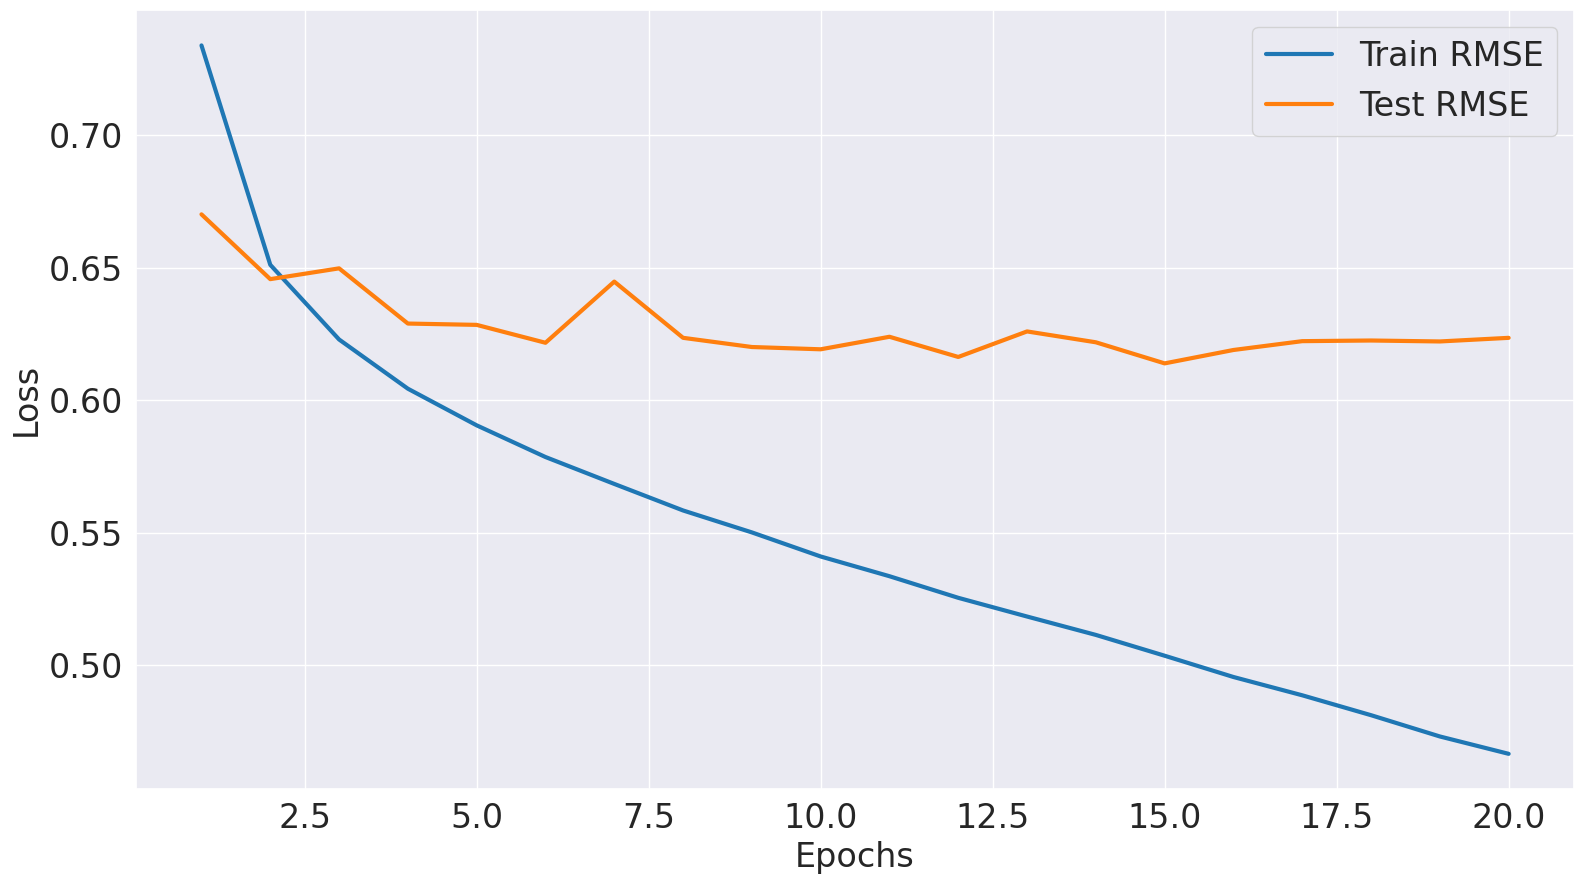

In [17]:
# Data/results directories
result_tag = 'esm_blstm-dms_binding' # specify expression or binding
data_dir = './data/processed_dms'
results_dir = './run_results/esm-blstm'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Run setup
n_epochs = 20
batch_size = 32
max_batch = -1
num_workers = 64
lr = 1e-5
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Create Dataset and DataLoader
torch.manual_seed(0)

dms_train_csv = os.path.join(data_dir, 'mutation_combined_binding_train.csv') # binding
dms_test_csv = os.path.join(data_dir, 'mutation_combined_binding_test.csv') 
trained_model_pth = "../results/run_results/esm-blstm/esm-blstm-esm_dms_binding-2023-12-12_17-02/esm-blstm-esm_dms_binding-2023-12-12_17-02_train_84420_test_21105.model_save"

train_dataset = DMSDataset(dms_train_csv)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

test_dataset = DMSDataset(dms_test_csv)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

# ESM input
esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

model = ESM_BLSTM(esm, blstm)
load_model_from_trained(model, trained_model_pth, device)

# Run
count_parameters(model)
saved_model_pth = None
from_checkpoint = False
save_as = f"{result_tag}-train_{len(train_dataset)}_test_{len(test_dataset)}"
run_model(model, tokenizer, train_data_loader, test_data_loader, n_epochs, lr, max_batch, device, run_dir, save_as, saved_model_pth, from_checkpoint)